# Fraud Detection

## Import required modules

In [64]:
get_ipython().magic(u'matplotlib inline')
from __future__ import division
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd
import seaborn as sns

## Read and preview data

We read the `data_for_student_case.csv` file and preview the data.

In [65]:
data = pd.read_csv('data/data_for_student_case.csv')
data.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [66]:
data.dtypes

txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
simple_journal                   object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                          object
ip_id                            object
card_id                          object
dtype: object

In [67]:
for x in data.columns:
    unique_values = set(data[x])
    if len(unique_values) < 100:
        print x,": ", unique_values


txvariantcode :  set(['visasignature', 'visaplatinum', 'mc', 'visacorporate', 'visagold', 'visaclassic', 'mcdebit', 'electron', 'visa', 'visabusiness', 'visadebit', 'visapurchasing', 'vpay', 'mccredit', 'cirrus'])
currencycode :  set(['MXN', 'SEK', 'AUD', 'GBP', 'NZD'])
shopperinteraction :  set(['ContAuth', 'Ecommerce', 'POS'])
simple_journal :  set(['Refused', 'Settled', 'Chargeback'])
cardverificationcodesupplied :  set([False, True, nan])
cvcresponsecode :  set([0, 1, 2, 3, 5])
accountcode :  set(['UKAccount', 'APACAccount', 'SwedenAccount', 'MexicoAccount'])


In [68]:
data.describe() #the only relevant desciption is the amount attribute

,txid,bin,amount,cvcresponsecode
count,290382.000000,290242.000000,2.903820e+05,290382.000000
mean,279916.750673,485254.586238,2.936462e+04,0.769004
std,138437.214796,37015.528140,6.829927e+04,0.508933
min,1.000000,400000.000000,5.000000e+01,0.000000
25%,218232.250000,462239.000000,4.400000e+03,0.000000
50%,304071.500000,475139.000000,7.095000e+03,1.000000
75%,387592.750000,518652.000000,1.589500e+04,1.000000
max,482734.000000,676883.000000,2.785840e+06,5.000000


## Preprocessing

Some preprocessing steps that we try to apply are:
* Remove the `refused` transactions, because their fraudulent ambiguity
* Transform creationdate to pandas datetime
* Reduce the possible number of CVC response code (as it is 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked) to 0, 1, and 3
* Map float columns which supposed to be categorical / identifier (`bin` and `cvcresponsecode`)
* Convert to EURO
* Assign fraudulent label based on `simple_journal` attribute (fraudulent = 1 if simple_journal='chargeback', else fraudulent = 0)

### Remove 'refused' transactions

In [69]:
data_preproc = data.loc[data['simple_journal'] != 'Refused'].copy()
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Transform date to pandas datetime

In [70]:
data_preproc['creationdate'] = pd.to_datetime(data_preproc['creationdate'])
# don't need to process booking date, will be removed anyway:
# data_preproc['bookingdate'] = pd.to_datetime(data_preproc['bookingdate'])
# convert datetime to timestamp
# data_preproc['ts'] = data_preproc.creationdate.values.astype(np.int64) // 10 ** 9
# print (data_preproc)

In [71]:
data_preproc[['bookingdate','creationdate']].dtypes

bookingdate             object
creationdate    datetime64[ns]
dtype: object

### Map cvcresponsecode with value 3-6 to 3

In [72]:
data_preproc['cvcresponsecode'] = map(lambda x: 3 if int(x) >= 3 else int(x), data_preproc['cvcresponsecode'])

### Map to categorical and object (for identifier) datatype

In [73]:
data_preproc['bin'] = data_preproc['bin'].astype(int)
data_preproc['bin'] = data_preproc['bin'].astype(str)
data_preproc['txid'] = data_preproc['txid'].astype(str)
for category_column in ["txvariantcode","currencycode","shopperinteraction","simple_journal","cardverificationcodesupplied","cvcresponsecode","accountcode"]:  
    data_preproc[category_column] = data_preproc[category_column].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                       object
txvariantcode                         category
bin                                     object
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
simple_journal                        category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
dtype: object

### Convert amount to EURO currencies

In [74]:
from currency_converter import CurrencyConverter

currency_converter = CurrencyConverter()
data_preproc['amount_euro'] = map(lambda x,y: currency_converter.convert(x,y, 'EUR'), data_preproc['amount'],data_preproc['currencycode'])
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_euro
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2809.743914
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1946.875027
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6499.700814
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4765.290991
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3898.086079


### Apply fraudulent label

In [75]:
data_preproc['is_fraud'] = data_preproc.apply(lambda x: 1 if x['simple_journal'] == "Chargeback" else 0, axis=1)
# remove the simple_journal column
data_preproc = data_preproc.drop(['simple_journal'],axis=1)
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_euro,is_fraud
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2809.743914,1
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1946.875027,1
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6499.700814,1
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4765.290991,1
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3898.086079,1


In [76]:
data_preproc['is_fraud'] = data_preproc['is_fraud'].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                       object
txvariantcode                         category
bin                                     object
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
amount_euro                            float64
is_fraud                              category
dtype: object

### Remove bookingdate
Certain bookingdate indicates that the transaction is indeed fraudulent, so we may not use it for training our classifier

In [77]:
data_preproc = data_preproc.drop(['bookingdate'],axis=1)
data_preproc.head()

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_euro,is_fraud
0,1,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2809.743914,1
1,2,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1946.875027,1
2,3,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6499.700814,1
3,4,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4765.290991,1
4,5,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3898.086079,1


## Visualization Task
We try the following visualization:
* Distribution histogram
* Heat map
* Scatter plot
* Bar chart
* Box plot

### Distribution histogram

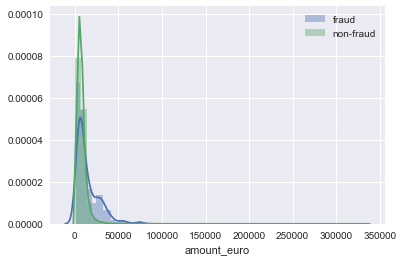

In [78]:
fraud = data_preproc.loc[data_preproc['is_fraud'] == 1]
non_fraud = data_preproc.loc[data_preproc['is_fraud'] == 0]
plt.figure("Amount Distribution (Fraud vs Non-Fraud)")
sns.distplot(fraud['amount_euro'], label="fraud")
sns.distplot(non_fraud['amount_euro'], label="non-fraud")
plt.legend()
plt.show()

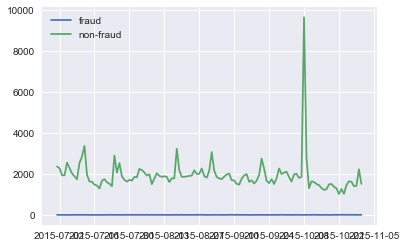

In [79]:
temp_fraud = fraud.set_index('creationdate').resample('1D').count()['txid']
x_fraud = temp_fraud.index
y_fraud = temp_fraud.values

temp_non_fraud = non_fraud.set_index('creationdate').resample('1D').count()['txid']
x_non_fraud = temp_non_fraud.index
y_non_fraud = temp_non_fraud.values


plt.figure()
plt.plot(x_fraud, y_fraud, label="fraud");
plt.plot(x_non_fraud, y_non_fraud, label="non-fraud");
plt.legend()
plt.show()

### Heat map

We try to plot a heat map in regards of percentage of fraudulent transaction

In [80]:
import itertools

def fraud_heatmap(column_name_a, column_name_b, frac=True):
    # column_name_a = 'currencycode'
    # column_name_b = 'accountcode'

    x_axis = list(set(data_preproc[column_name_a]))
    y_axis = list(set(data_preproc[column_name_b]))
    values = []

    length_x = len(x_axis)
    length_y = len(y_axis)
    x_axis = np.repeat(x_axis, length_y)
    y_axis = y_axis*length_x


    for combination in zip(x_axis, y_axis):
        # number of fraud
        num_fraud = len(fraud.loc[(fraud[column_name_a] == combination[0]) & (fraud[column_name_b] == combination[1])])
        num_total = len(data_preproc.loc[(data_preproc[column_name_a] == combination[0]) & (data_preproc[column_name_b] == combination[1])])
        
        if frac:
            if num_total == 0:
                values.append(0)
            else:
                values.append(num_fraud / float(num_total))
        else: 
            values.append(num_fraud)

    df = pd.DataFrame({column_name_a: x_axis, column_name_b: y_axis, 'value': values })

    # plot it
    df_wide=df.pivot_table( index=column_name_a, columns=column_name_b, values='value' )
    sns.set(rc={"figure.figsize": (10, 10)})
    sns.heatmap( df_wide, cmap="Blues")

In [85]:
# select categorical columns
categorical_columns = [x for x in data_preproc.columns if hasattr(data_preproc[x], 'cat')]
# remove is_fraud
categorical_columns = categorical_columns[:-1]

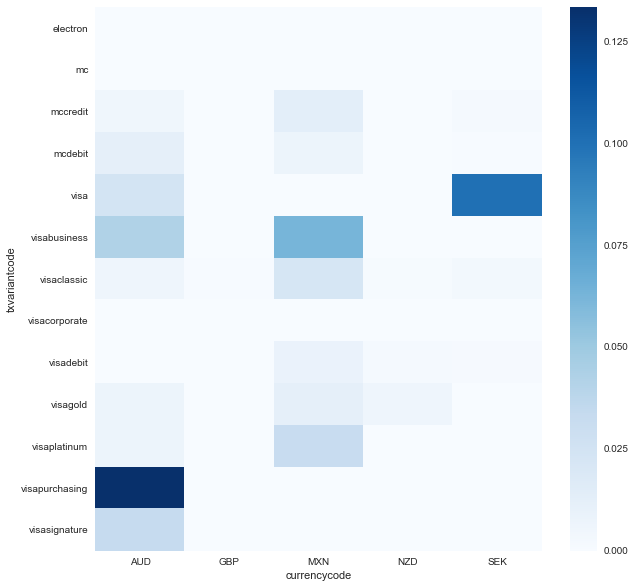

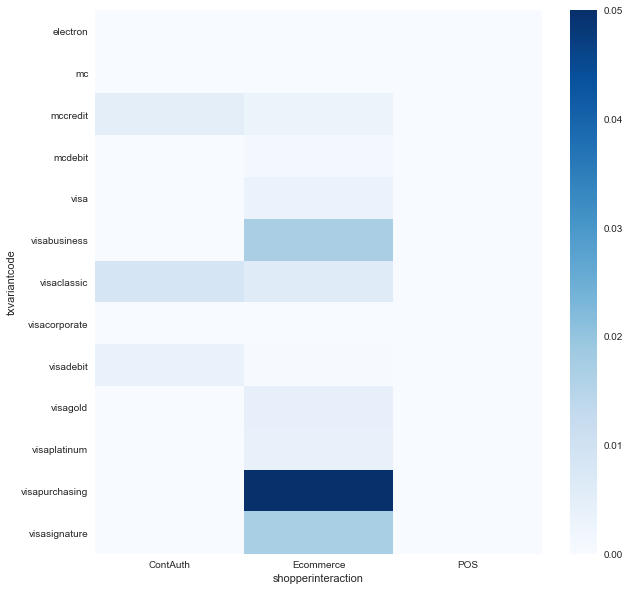

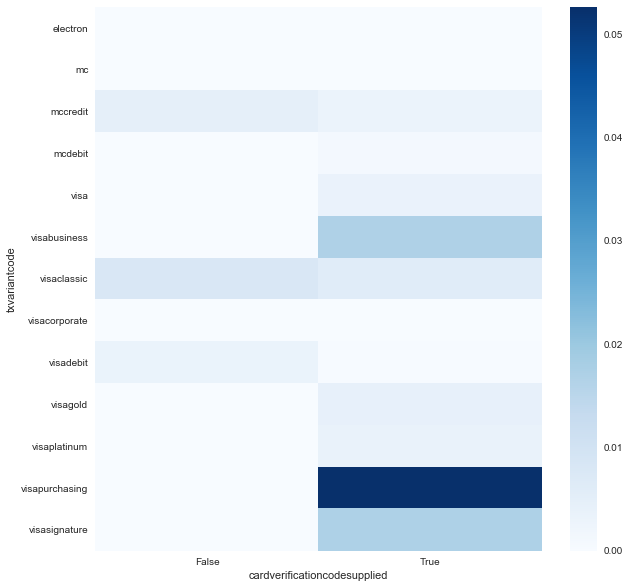

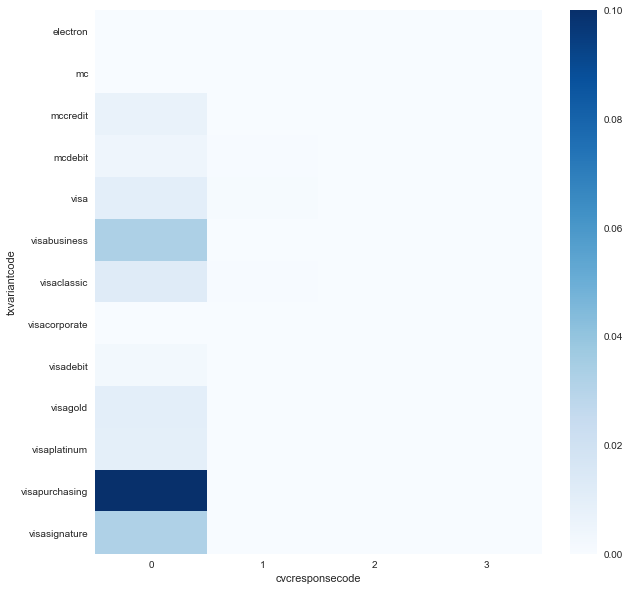

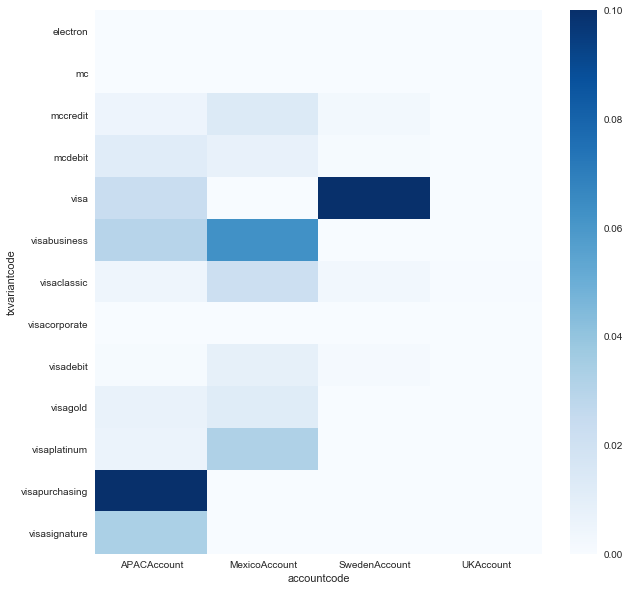

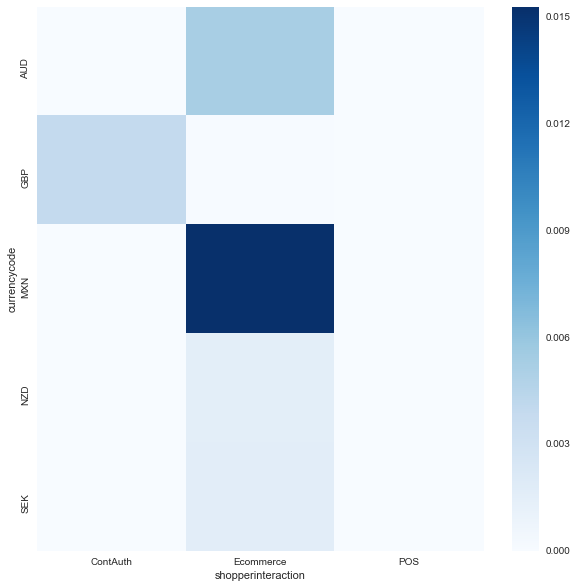

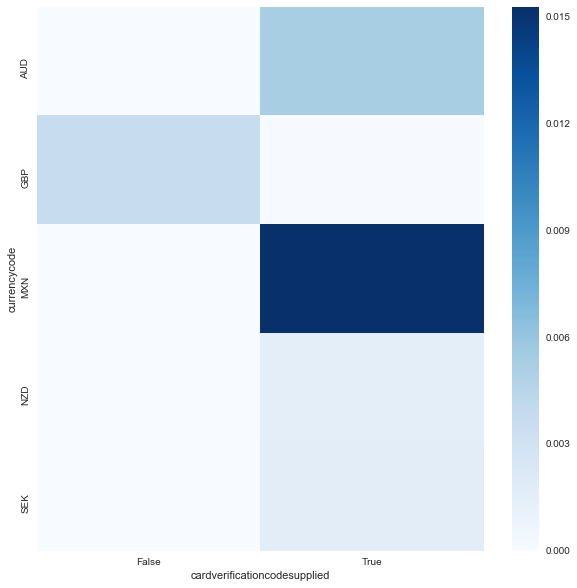

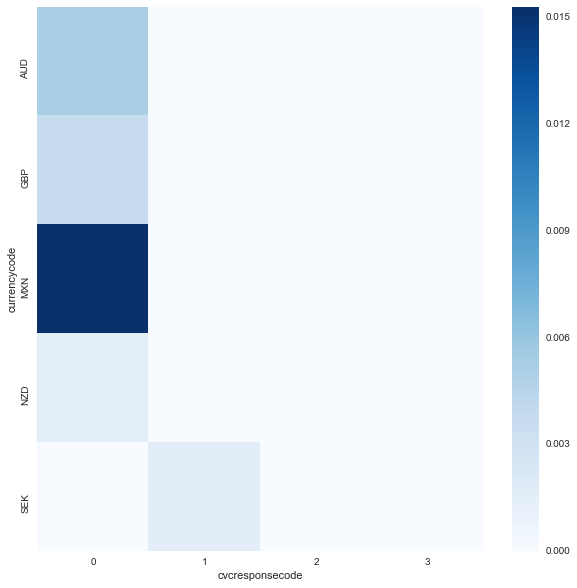

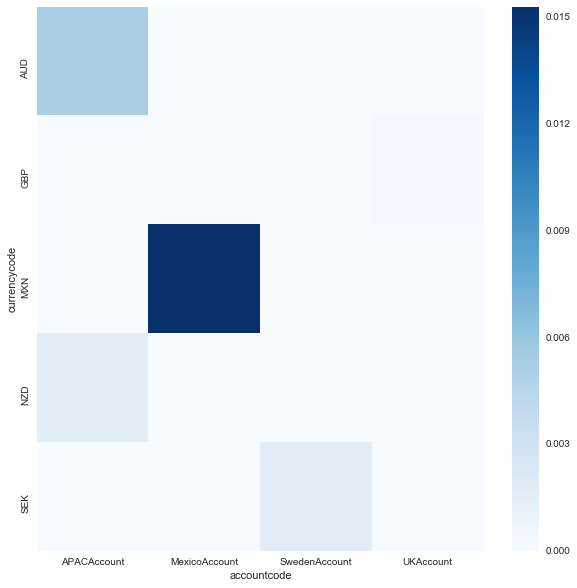

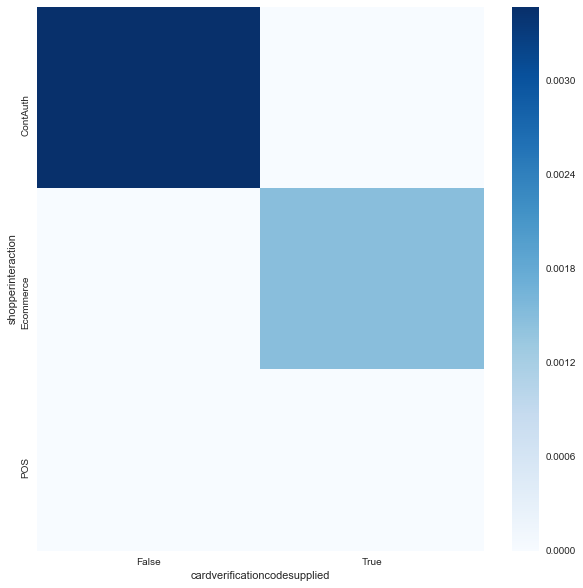

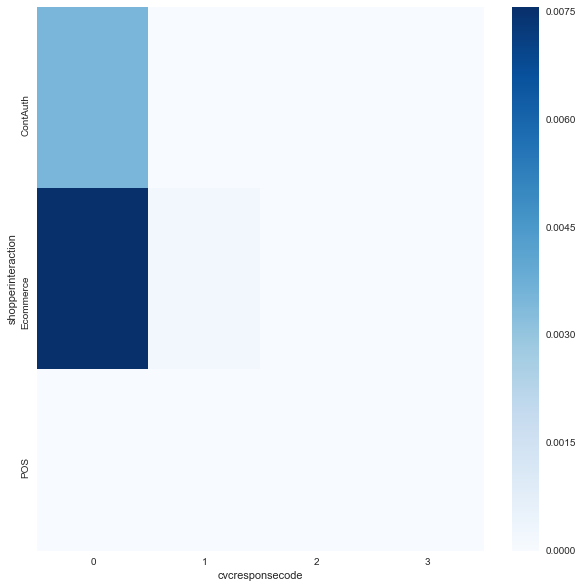

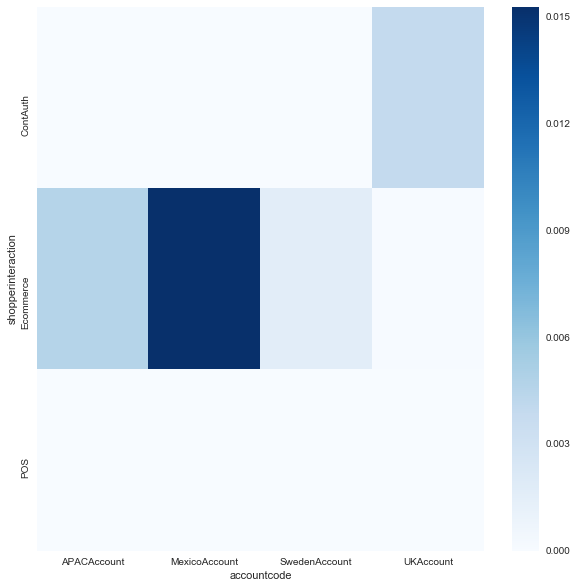

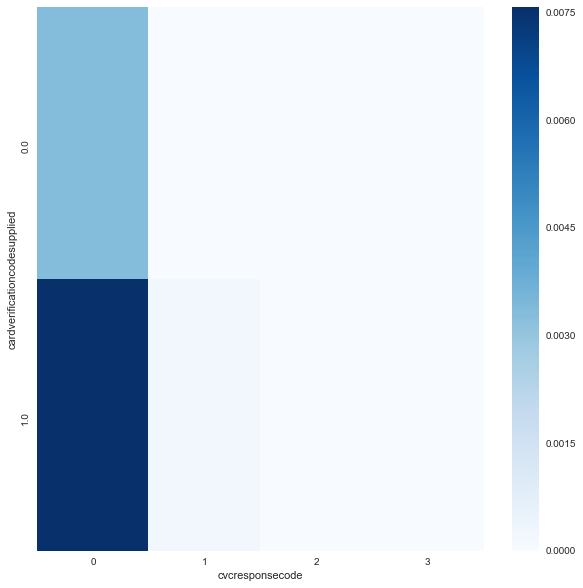

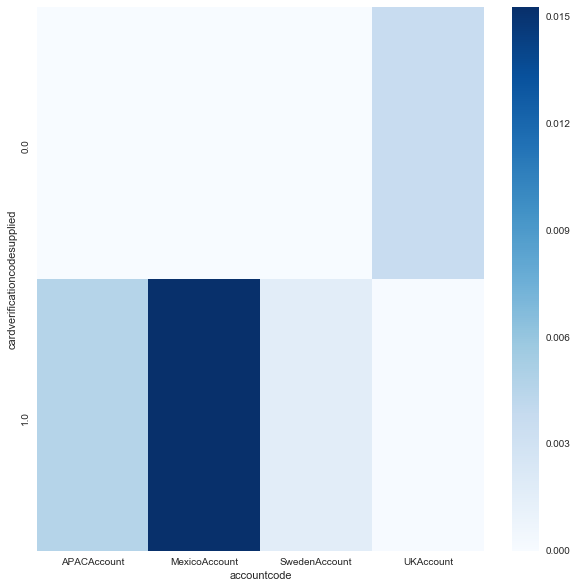

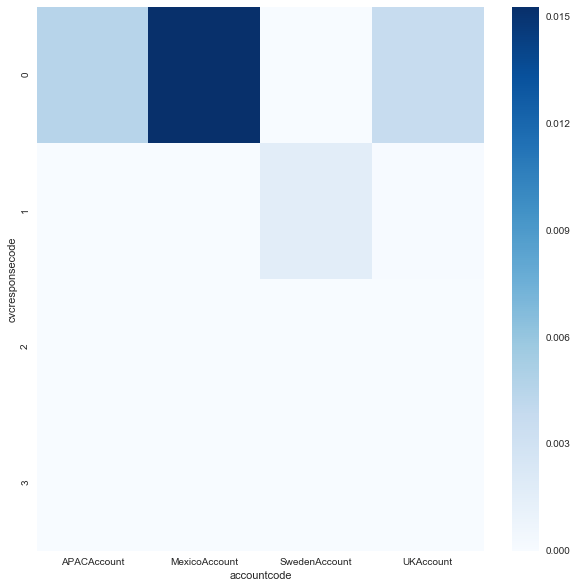

In [86]:
for combination in list(itertools.combinations(categorical_columns,2)):
    fraud_heatmap(combination[0], combination[1], frac=True)
    plt.show()

## Imbalance Task

## Classification Task